In [1]:
import time
import copy
import pandas as pd
import torch
from torch.autograd import Variable
from densenet import densenet169
from utils import plot_training, n_p, get_count
from train import train_model, get_metrics
from pipeline import get_study_level_data, get_dataloaders

In [2]:
study_data = get_study_level_data(study_type='XR_HUMERUS')

100%|███████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 344.67it/s]


In [3]:
data_cat = ['train', 'valid'] # data categories
dataloaders = get_dataloaders(study_data, batch_size=1)
dataset_sizes = {x: len(study_data[x]) for x in data_cat}

In [4]:
tai = {x: get_count(study_data[x], 'positive') for x in data_cat}
tni = {x: get_count(study_data[x], 'negative') for x in data_cat}
Wt1 = {x: n_p(tni[x] / (tni[x] + tai[x])) for x in data_cat}
Wt0 = {x: n_p(tai[x] / (tni[x] + tai[x])) for x in data_cat}

In [5]:
print('tai:', tai)
print('tni:', tni, '\n')
print('Wt0 train:', Wt0['train'])
print('Wt0 valid:', Wt0['valid'])
print('Wt1 train:', Wt1['train'])
print('Wt1 valid:', Wt1['valid'])

tai: {'train': 599, 'valid': 140}
tni: {'train': 673, 'valid': 148} 

Wt0 train: tensor([0.4709], device='cuda:0')
Wt0 valid: tensor([0.4861], device='cuda:0')
Wt1 train: tensor([0.5291], device='cuda:0')
Wt1 valid: tensor([0.5139], device='cuda:0')


In [6]:
class Loss(torch.nn.modules.Module):
    def __init__(self, Wt1, Wt0):
        super(Loss, self).__init__()
        self.Wt1 = Wt1
        self.Wt0 = Wt0
        
    def forward(self, inputs, targets, phase):
        loss = - (self.Wt1[phase] * targets * inputs.log() + self.Wt0[phase] * (1 - targets) * (1 - inputs).log())
        return loss

In [7]:
model = densenet169(pretrained=True)
model = model.cuda()

C:\Users\doshi\New project\densenet.py:115: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [8]:
criterion = Loss(Wt1, Wt0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True)

Train batches: 592
Valid batches: 135 

Epoch 1/10
----------


C:\Users\doshi\Anaconda3\envs\test\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train Loss: 0.3454 Acc: 0.5287
Confusion Meter:
 [[ 0.56697822  0.43302181]
 [ 0.51660514  0.48339483]]
valid Loss: 0.4008 Acc: 0.5630
Confusion Meter:
 [[ 0.57352942  0.42647058]
 [ 0.44776121  0.55223882]]
Time elapsed: 4m 29s

Epoch 2/10
----------
train Loss: 0.3427 Acc: 0.5507
Confusion Meter:
 [[ 0.56697822  0.43302181]
 [ 0.46863469  0.53136533]]
valid Loss: 0.3737 Acc: 0.5704
Confusion Meter:
 [[ 0.57352942  0.42647058]
 [ 0.43283582  0.56716418]]
Time elapsed: 8m 51s

Epoch 3/10
----------
train Loss: 0.3454 Acc: 0.5101
Confusion Meter:
 [[ 0.63551402  0.36448598]
 [ 0.63837636  0.36162362]]
valid Loss: 0.5199 Acc: 0.4963
Confusion Meter:
 [[ 0.54411763  0.45588234]
 [ 0.55223882  0.44776121]]
Time elapsed: 13m 11s

Epoch 4/10
----------
train Loss: 0.3358 Acc: 0.5912
Confusion Meter:
 [[ 0.61682242  0.38317758]
 [ 0.43911439  0.56088561]]
valid Loss: 0.5316 Acc: 0.5259
Confusion Meter:
 [[ 0.54411763  0.45588234]
 [ 0.49253732  0.50746268]]
Epoch     3: reducing learning rate

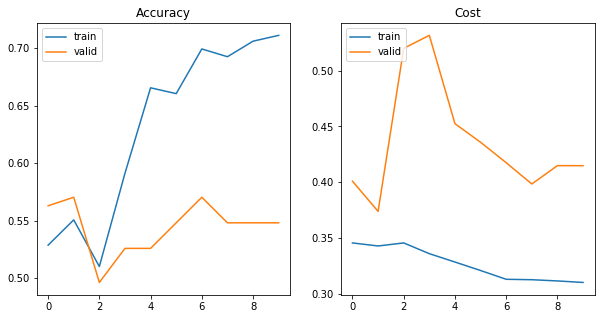

In [9]:
model = train_model(model, criterion, optimizer, dataloaders, scheduler, dataset_sizes, num_epochs=10)

In [10]:
torch.save(model.state_dict(), 'C:/Users/doshi/New project/model.pth')

In [11]:
get_metrics(model, criterion, dataloaders, dataset_sizes)

C:\Users\doshi\Anaconda3\envs\test\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid Loss: 0.7856 Acc: 0.5704
Confusion Meter:
 [[ 0.57352942  0.42647058]
 [ 0.43283582  0.56716418]]
